![banner.png](https://storage.googleapis.com/kaggle-competitions/kaggle/5407/media/housesbanner.png)

# Ames Housing Data
Estates Agent are looking for the way to accurately predict saleprice of housing in Ames. By using data science to predict the prices, we will be able to come up with more competitive prices. We are also looking for features that homeowners can look into to potentially improve the property's sales value.
## Problem Statement

Create a regression model where we are able to see which features affect the price of property at sales in Iowa Ames

## Executive Summary

The data set that we will be exploring is the Ames Iowa Housing Dataset till the year 2010. In the Dataset there is a total of 81 features and 2051 columns. We will explore the data to see the correlation the features have to SalePrice, and also to build a regression model to predict the SalePrice of housing.

The final Kaggle models using Lasso, Ridge Regression uses 120 features to do the prediction with a RMSE score of around 28,000. At the end of the project, we will use the top 50 coefficient features to do our recommendations to homeowners and how they can improve their property prices using those features.

### Contents:
- [7. Model_Benchmarks](#7.-Model-Benchmarks)
- [8. Model_Tuning](#8.-Model-Tuning)
- [9. Kaggle Submission](#9.-Kaggle-Submission)
- [10. Analysis & Recommendation](#10.-Analysis)


Links:
[Kaggle challenge link](https://www.kaggle.com/c/dsi-us-6-project-2-regression-challenge/data)

# 7. Model Benchmarks
<a href='#7.-Model-Benchmarks'></a>

In [1]:
#Imports:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from itertools import compress

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFECV

plt.style.use('ggplot')

from IPython.display import display
pd.set_option('display.max_rows', 3000)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)

In [2]:
# Importing cleaned dataset for Pre Processing
df_train= pd.read_csv('../datasets/train_preprocess.csv')

df_train.shape

(2018, 143)

## 7.1 Train Test Split

In [3]:
col_keys = df_train.drop(columns = ['Id','SalePrice']).keys()
col_keys

Index(['Year Built', 'Year Remod/Add', 'Bsmt Qual', 'Central Air', '1st Flr SF', 'Full Bath', 'Kitchen Qual', 'TotRms AbvGrd', 'Garage Finish', 'Garage Cars',
       ...
       'Heating_GasW', 'Heating_Grav', 'Heating_OthW', 'Heating_Wall', 'Garage Type_2Types', 'Garage Type_Attchd', 'Garage Type_Basment', 'Garage Type_BuiltIn', 'Garage Type_CarPort', 'Garage Type_Detchd'], dtype='object', length=141)

In [4]:
y = df_train['SalePrice']
X = df_train[col_keys]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42, test_size = 0.2)

In [6]:
print('X_train shape: ' + str(X_train.shape))
print('X_test shape: ' + str(X_test.shape))
print('y_train shape: ' + str(y_train.shape))
print('y_test shape: ' + str(y_test.shape))

X_train shape: (1614, 141)
X_test shape: (404, 141)
y_train shape: (1614,)
y_test shape: (404,)


## 7.1.1 Linear

In [7]:
lr = LinearRegression()

In [8]:
lr.fit(X_train, y_train)

LinearRegression()

In [9]:
print("Train Score(Lr): " + str(lr.score(X_train,y_train)))
print("Test Score(Lr): " + str(lr.score(X_test,y_test)))
print('Test Data Estimated score(Lr) ' + str(cross_val_score(lr, X_train, y_train, cv = 5).mean()))

Train Score(Lr): 0.8979960906719422
Test Score(Lr): 0.8704370421540691
Test Data Estimated score(Lr) -8.607795662776115e+19


In [10]:
print("Train RMSE(Lr) " + str(np.sqrt(mean_squared_error(y_train, lr.predict(X_train)))))
print('Test RMSE(Lr) ' + str(np.sqrt(mean_squared_error(y_test, lr.predict(X_test)))))
                              
print('Test Data Estimated RMSE(Lr) ' + str(np.sqrt(-cross_val_score(lr, X_train, y_train, 
                                                            cv = 5, scoring = 'neg_mean_squared_error')).mean()))

Train RMSE(Lr) 23224.50639520925
Test RMSE(Lr) 26995.091582260902
Test Data Estimated RMSE(Lr) 535146332955611.8


In [11]:
#function to plot residual and prediction plot
def model_evaluation_plots(model, X_train, y_train, X_test, y_test):
    y_train_preds = model.predict(X_train)
    y_test_preds = model.predict(X_test)
    
    plt.figure(figsize=(12,6))
    # Residuals
    plt.subplot(121)
    plt.scatter(y_train_preds, y_train_preds - y_train, c='tomato', marker='o', label='Training data')
    plt.scatter(y_test_preds, y_test_preds - y_test, c='gold', marker='s', label='Validation data')
    plt.title('Residuals')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.legend(loc='upper left')
    plt.hlines(y=0, xmin=y_train.min(), xmax=y_train.max(), color='blue')

    # Predictions
    plt.subplot(122)
    plt.scatter(y_train_preds, y_train, c='tomato', marker='o', label='Training data')
    plt.scatter(y_test_preds, y_test, c='gold', marker='s', label='Validation data')
    plt.title('Predictions')
    plt.xlabel('Predicted values')
    plt.ylabel('Real values')
    plt.legend(loc='upper left')
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c='blue')
    plt.tight_layout()
    plt.show()

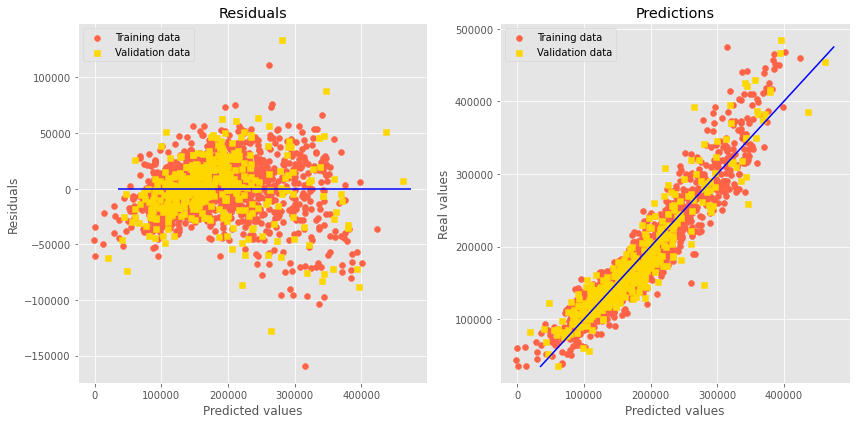

In [12]:
model_evaluation_plots(lr, X_train, y_train, X_test, y_test)

### 7.1.1 comments 
- Terrible result, models is severely overfitted resulting in a negative r2 value
- Will use Ridge, Lasso and Elastic model to regularize data

## 7.2 Cross Validation with Ridge, Lasso and ElasticNet

### 7.1.2 Ridge

In [13]:
ridge = Ridge()

In [14]:
ridge.fit(X_train, y_train);

In [15]:
print("Train Score(L1): " + str(ridge.score(X_train,y_train)))
print("Test Score(L1): " + str(ridge.score(X_test,y_test)))
print('Test Data Estimated score(L1) ' + str(cross_val_score(ridge, X_train, y_train, cv = 5).mean()))

Train Score(L1): 0.9019689760809767
Test Score(L1): 0.8788958335564692
Test Data Estimated score(L1) 0.8801831971668783


In [16]:
print("Train RMSE(L1) " + str(np.sqrt(mean_squared_error(y_train, ridge.predict(X_train)))))
print('Test RMSE(L1) ' + str(np.sqrt(mean_squared_error(y_test, ridge.predict(X_test)))))
                              
print('Test Data Estimated RMSE(L1) ' + str(np.sqrt(-cross_val_score(ridge, X_train, y_train, 
                                                            cv = 5, scoring = 'neg_mean_squared_error').mean())))

Train RMSE(L1) 22767.73634580609
Test RMSE(L1) 26099.003191865584
Test Data Estimated RMSE(L1) 25158.89979354187


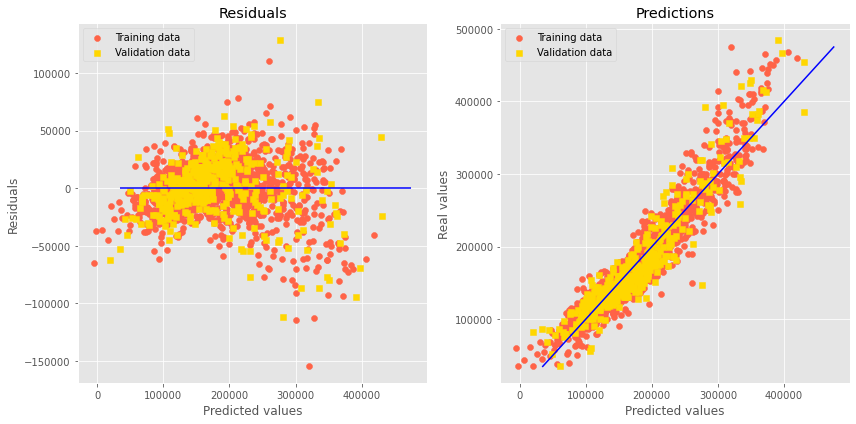

In [17]:
model_evaluation_plots(ridge, X_train, y_train, X_test, y_test)

### 7.1.3 Lasso

In [18]:
lasso = Lasso(max_iter = 2000)

In [19]:
lasso.fit(X_train, y_train);

In [20]:
print("Train Score(L2): " + str(lasso.score(X_train,y_train)))
print("Test Score(L2): " + str(lasso.score(X_test,y_test)))
print('Test Data Estimated score(L2) ' + str(cross_val_score(lasso, X_train, y_train, cv = 5).mean()))

Train Score(L2): 0.9029873611737526
Test Score(L2): 0.8768041921057456
Test Data Estimated score(L2) 0.8771429304709158


In [21]:
print("Train RMSE(L2) " + str(np.sqrt(mean_squared_error(y_train, lasso.predict(X_train)))))
print('Test RMSE(L2) ' + str(np.sqrt(mean_squared_error(y_test, lasso.predict(X_test)))))
                              
print('Test Data Estimated RMSE(L2) ' + str(np.sqrt(-cross_val_score(lasso, X_train, y_train, 
                                                            cv = 5, scoring = 'neg_mean_squared_error').mean())))

Train RMSE(L2) 22649.167476667066
Test RMSE(L2) 26323.42181262805
Test Data Estimated RMSE(L2) 25479.927791346585


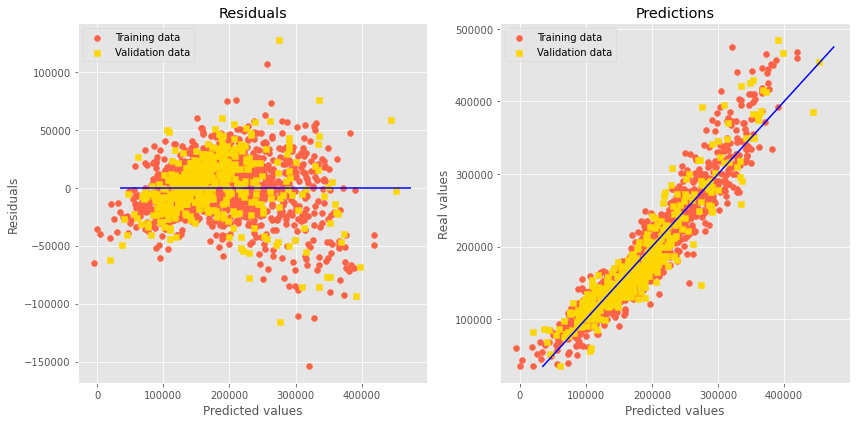

In [22]:
model_evaluation_plots(lasso, X_train, y_train, X_test, y_test)

### 7.1.4 Elastic Net

In [23]:
elasticnet = ElasticNet()

In [24]:
elasticnet.fit(X_train, y_train);

In [25]:
print("Train Score(EN): " + str(elasticnet.score(X_train,y_train)))
print("Test Score(EN): " + str(elasticnet.score(X_test,y_test)))
print('Test Data Estimated score(EN) ' + str(cross_val_score(elasticnet, X_train, y_train, cv = 5).mean()))

Train Score(EN): 0.8416572498428068
Test Score(EN): 0.8268560734766441
Test Data Estimated score(EN) 0.8386771366069639


In [26]:
print("Train RMSE(EN) " + str(np.sqrt(mean_squared_error(y_train, elasticnet.predict(X_train)))))
print('Test RMSE(EN) ' + str(np.sqrt(mean_squared_error(y_test, elasticnet.predict(X_test)))))
                              
print('Test Data Estimated RMSE(EN) ' + str(np.sqrt(-cross_val_score(elasticnet, X_train, y_train, 
                                                            cv = 5, scoring = 'neg_mean_squared_error').mean())))

Train RMSE(EN) 28935.91206789939
Test RMSE(EN) 31206.711727875314
Test Data Estimated RMSE(EN) 29194.12520798453


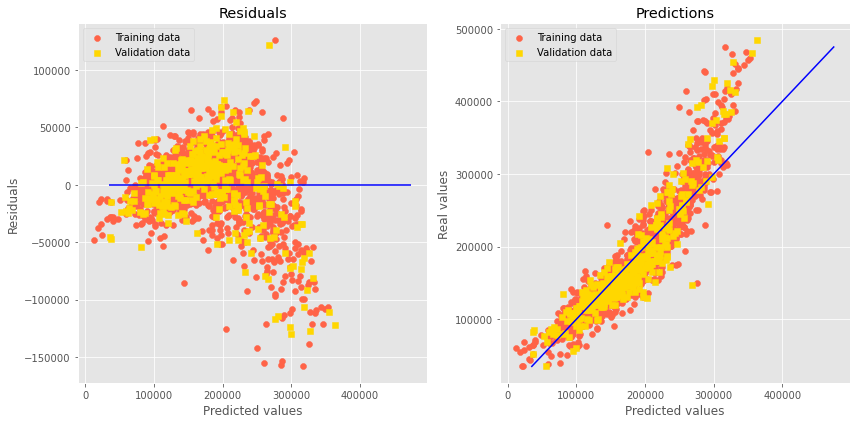

In [27]:
model_evaluation_plots(elasticnet, X_train, y_train, X_test, y_test)

### 7 comments

- the prediction is better after regularising
- all lasso and ridge models are producing very similar RMSE and R2 scores
- ElasticNet model seems to do very badly
- there seems to be a spread of residuals in all 3 models
- the data seem to move away from best fit line at higher prices
- will manually remove coefficient since there is sign of overfitting, with train r2 higher then test r2

# 8 Model Tuning
<a href='#8.-Model-Tuning'></a>

- Will use RFECV to select the best features for further model tuning

In [28]:
rfecv = RFECV(lasso, step = 1, #using lasso model as the results are better among the 3 models
             min_features_to_select = 30,  #minimum of 30 features
             cv=5,
             scoring = 'neg_mean_squared_error') #calculating using mse

rfecv.fit(X_train, y_train)

RFECV(cv=5, estimator=Lasso(max_iter=2000), min_features_to_select=30,
      scoring='neg_mean_squared_error')

In [29]:
gd_coef = list(compress(X_train.columns, rfecv.support_))
print(str(len(gd_coef)) + ' features left after RFECV feature selection')

94 features left after RFECV feature selection


In [30]:
#preparing filtered data for model
X_train_filtered = X_train[gd_coef] 
X_test_filtered = X_test[gd_coef]

## 8.1 Linear

In [31]:
lr = LinearRegression()
lr.fit(X_train_filtered, y_train)

LinearRegression()

In [32]:
print("Train Score(Lr): " + str(lr.score(X_train_filtered,y_train)))
print("Test Score(Lr): " + str(lr.score(X_test_filtered,y_test)))
print('Test Data Estimated score(Lr) ' + str(cross_val_score(lr, X_train_filtered, y_train, cv = 5).mean()))

Train Score(Lr): 0.8813726225431241
Test Score(Lr): 0.8523255227266613
Test Data Estimated score(Lr) -5.507207005045258e+21


In [33]:
print("Train RMSE(Lr) " + str(np.sqrt(mean_squared_error(y_train, lr.predict(X_train_filtered)))))
print('Test RMSE(Lr) ' + str(np.sqrt(mean_squared_error(y_test, lr.predict(X_test_filtered)))))
                              
print('Test Data Estimated RMSE(Lr) ' + str(np.sqrt(-cross_val_score(lr, X_train_filtered, y_train, 
                                                            cv = 5, scoring = 'neg_mean_squared_error').mean())))

Train RMSE(Lr) 25045.548594392018
Test RMSE(Lr) 28820.20722831757
Test Data Estimated RMSE(Lr) 5556735808268623.0


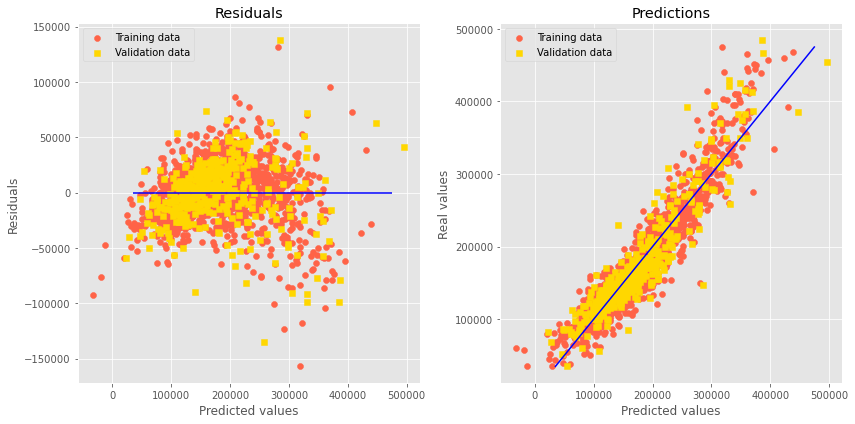

In [34]:
model_evaluation_plots(lr, X_train_filtered, y_train, X_test_filtered, y_test)

###  8.1 Comments

- model improved after fine tuning
- will use Lasso and Ridge model to further fine tune the model

## 8.2 Lasso

In [35]:
lassocv = LassoCV(alphas = np.linspace(0.1,100,100), max_iter = 1500)

In [36]:
lassocv.fit(X_train_filtered, y_train);

In [37]:
lassocv.alpha_

29.363636363636363

In [38]:
print("Train Score(L2): " + str(lassocv.score(X_train_filtered,y_train)))
print("Test Score(L2): " + str(lassocv.score(X_test_filtered,y_test)))
print('Test Data Estimated score(L2) ' + str(cross_val_score(lassocv, X_train_filtered, y_train, cv = 5).mean()))

Train Score(L2): 0.8990693846003368
Test Score(L2): 0.8767080661051813
Test Data Estimated score(L2) 0.8826541598572726


In [39]:
print("Train RMSE(L2) " + str(np.sqrt(mean_squared_error(y_train, lassocv.predict(X_train_filtered)))))
print('Test RMSE(L2) ' + str(np.sqrt(mean_squared_error(y_test, lassocv.predict(X_test_filtered)))))
                              
print('Test Data Estimated RMSE(L2) ' + str(np.sqrt(-cross_val_score(lassocv, X_train_filtered, y_train, 
                                                            cv = 5, scoring = 'neg_mean_squared_error').mean())))

Train RMSE(L2) 23101.99815311924
Test RMSE(L2) 26333.689499100772
Test Data Estimated RMSE(L2) 24892.52851107071


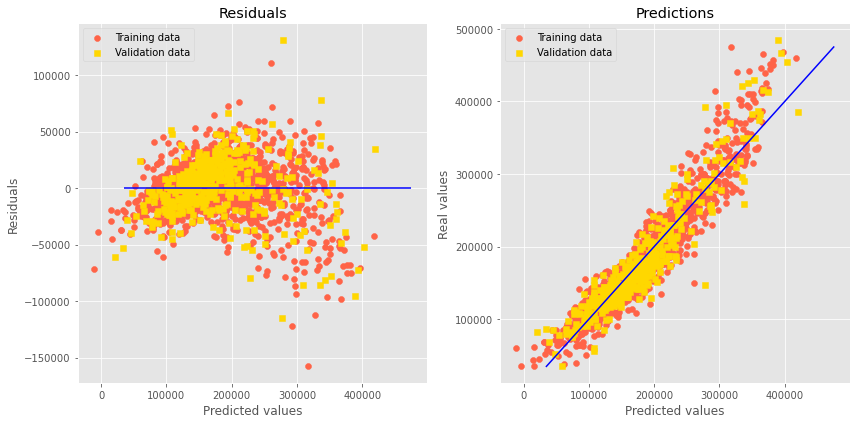

In [40]:
model_evaluation_plots(lassocv, X_train_filtered, y_train, X_test_filtered, y_test)

- Not surprisingly, the RMSE and R2 scores are very similar to Linear model
- the prediction are still not that good at higher pricest

## 8.3 Further Model tuning

- Polynomial features, to see if we can increase accuracy of the model

### 8.3.1 Heatmap for features

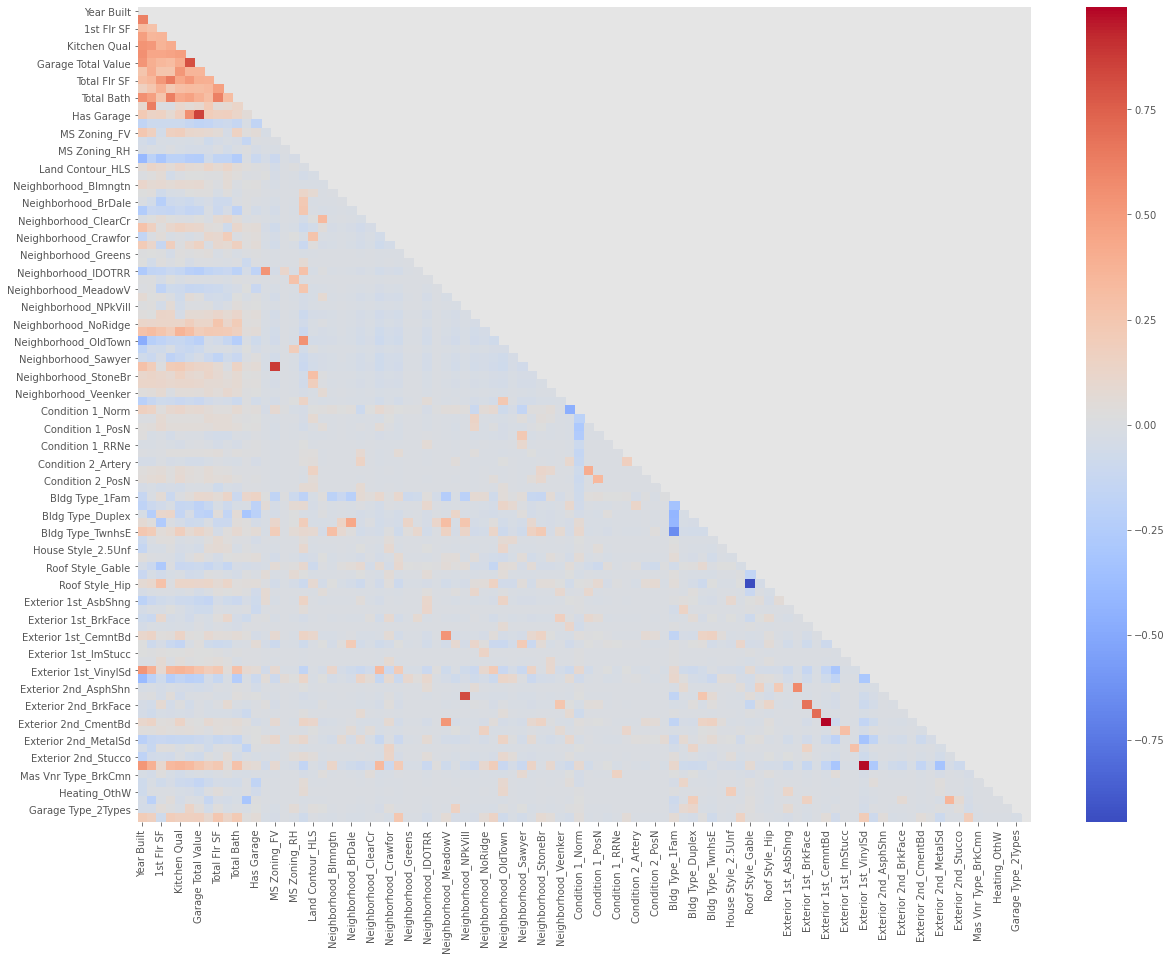

In [41]:
plt.figure(figsize= (20, 15))
mask = (np.triu(np.ones_like(df_train[gd_coef].corr(),
                             dtype=np.bool)))
sns.heatmap(df_train[gd_coef].corr(),
            annot=False, mask = mask, 
            fmt='.1g', cmap='coolwarm');

Very few patches of data with Correlation to each other

### 8.3.2 Adding in relevant Polynomial features to training and testing dataset

- will be choosing features where the correlation to saleprice increase alot more at higher prices
- '1st Flr SF', 'Garage Cars','Year Built', 'Overall Total Value', 'Garage Total Value', 'Total Bath', 'Total Flr SF', 'Kitchen Qual', 'Fireplace Total Value' are chosen as they are the only continuous data left after regularisation

### 8.3.3 Creating Polynomial Features

In [42]:
#def function to scatter plot data agaisnt sale price
def subplot_scatter(x, dataframe = df_train):
    nrows = int(np.ceil(len(x)/3)) # Makes sure you have enough rows
    fig, ax = plt.subplots(nrows=nrows, ncols=3, figsize=(15, 4*nrows)) # You'll want to specify your figsize
    plt.subplots_adjust(hspace = 0.4, wspace = 0.4)
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    for i, column in enumerate(x):  # Gives us an index value to get into all our lists
        sns.regplot(x = dataframe[column], 
                    y = dataframe['SalePrice'],
                    data = dataframe, 
                    ax = ax[i], line_kws = {'color':'b'})#plot Scatter plot for each data
        ax[i].set_xlabel(x[i])# Set x label for each plot

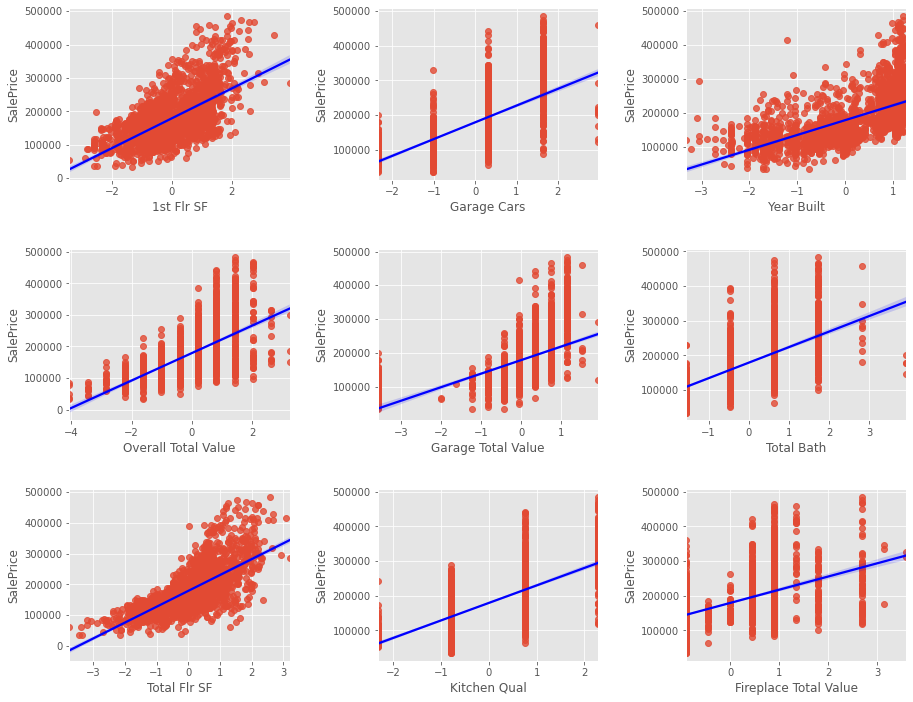

In [43]:
poly_coef = ['1st Flr SF', 'Garage Cars','Year Built', 'Overall Total Value', 'Garage Total Value',
             'Total Bath', 'Total Flr SF', 'Kitchen Qual', 'Fireplace Total Value']
subplot_scatter(poly_coef)

In [44]:
y = df_train['SalePrice']
X = df_train[poly_coef]

In [45]:
print("Garage & Total & Year Features RMSE(L2): " + 
      str(np.sqrt(-cross_val_score(lasso, X = X,y = y, cv = 5,
                                   scoring = 'neg_mean_squared_error').mean())))

Garage & Total & Year Features RMSE(L2): 30706.89039192311


In [46]:
poly = PolynomialFeatures(degree = 2, interaction_only = True, include_bias=False)

In [47]:
X_poly = poly.fit_transform(X)

In [48]:
print("Garage & Total & Year Polynomial Features RMSE(L2): " + 
      str(np.sqrt(-cross_val_score(lasso, X = X_poly, y = y, cv = 5,
                                   scoring = 'neg_mean_squared_error').mean())))

Garage & Total & Year Polynomial Features RMSE(L2): 23820.97583158794


- RMSE score improved after using polynomial features
- will include polynomial features to dataset

### 8.3.4 adding Polynomial Features into training dataset

In [49]:
poly_features = pd.DataFrame(X_poly, columns=poly.get_feature_names(poly_coef))
poly_features.drop(poly_coef, axis = 1, inplace = True)
poly_features.shape

(2018, 36)

In [50]:
poly_features.columns

Index(['1st Flr SF Garage Cars', '1st Flr SF Year Built', '1st Flr SF Overall Total Value', '1st Flr SF Garage Total Value', '1st Flr SF Total Bath', '1st Flr SF Total Flr SF', '1st Flr SF Kitchen Qual', '1st Flr SF Fireplace Total Value', 'Garage Cars Year Built', 'Garage Cars Overall Total Value', 'Garage Cars Garage Total Value', 'Garage Cars Total Bath', 'Garage Cars Total Flr SF', 'Garage Cars Kitchen Qual', 'Garage Cars Fireplace Total Value', 'Year Built Overall Total Value', 'Year Built Garage Total Value', 'Year Built Total Bath', 'Year Built Total Flr SF', 'Year Built Kitchen Qual', 'Year Built Fireplace Total Value', 'Overall Total Value Garage Total Value', 'Overall Total Value Total Bath', 'Overall Total Value Total Flr SF', 'Overall Total Value Kitchen Qual', 'Overall Total Value Fireplace Total Value', 'Garage Total Value Total Bath', 'Garage Total Value Total Flr SF', 'Garage Total Value Kitchen Qual', 'Garage Total Value Fireplace Total Value',
       'Total Bath Total

In [51]:
df_train_poly = pd.concat([df_train, poly_features], axis = 1)
df_train_poly.shape

(2018, 179)

## 8.4 Lasso Model with Polynomial Features

In [52]:
col_keys = df_train_poly.drop(columns = ['Id','SalePrice']).keys()
col_keys

Index(['Year Built', 'Year Remod/Add', 'Bsmt Qual', 'Central Air', '1st Flr SF', 'Full Bath', 'Kitchen Qual', 'TotRms AbvGrd', 'Garage Finish', 'Garage Cars',
       ...
       'Garage Total Value Total Bath', 'Garage Total Value Total Flr SF', 'Garage Total Value Kitchen Qual', 'Garage Total Value Fireplace Total Value', 'Total Bath Total Flr SF', 'Total Bath Kitchen Qual', 'Total Bath Fireplace Total Value', 'Total Flr SF Kitchen Qual', 'Total Flr SF Fireplace Total Value', 'Kitchen Qual Fireplace Total Value'], dtype='object', length=177)

In [53]:
y = df_train_poly['SalePrice']
X = df_train_poly[col_keys]

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42, test_size = 0.2)

In [55]:
print('X_train shape: ' + str(X_train.shape))
print('X_test shape: ' + str(X_test.shape))
print('y_train shape: ' + str(y_train.shape))
print('y_test shape: ' + str(y_test.shape))

X_train shape: (1614, 177)
X_test shape: (404, 177)
y_train shape: (1614,)
y_test shape: (404,)


In [56]:
lassocv = LassoCV(alphas = np.linspace(0.1,100,100), max_iter = 5000)
lassocv.fit(X_train, y_train);
lassocv.alpha_

30.37272727272727

In [57]:
print("Train Score(L2): " + str(lassocv.score(X_train,y_train)))
print("Test Score(L2): " + str(lassocv.score(X_test,y_test)))
print('Test Data Estimated score(L2) ' + str(cross_val_score(lassocv, X_train, y_train, cv = 5).mean()))

Train Score(L2): 0.9305832268981639
Test Score(L2): 0.9167973376332562
Test Data Estimated score(L2) 0.90996213013405


In [58]:
print("Train RMSE(L2) " + str(np.sqrt(mean_squared_error(y_train, lassocv.predict(X_train)))))
print('Test RMSE(L2) ' + str(np.sqrt(mean_squared_error(y_test, lassocv.predict(X_test)))))
                              
print('Test Data Estimated RMSE(L2) ' + str(np.sqrt(-cross_val_score(lassocv, X_train, y_train, 
                                                            cv = 5, scoring = 'neg_mean_squared_error').mean())))

Train RMSE(L2) 19158.887831562504
Test RMSE(L2) 21632.812682747335
Test Data Estimated RMSE(L2) 21804.72730647049


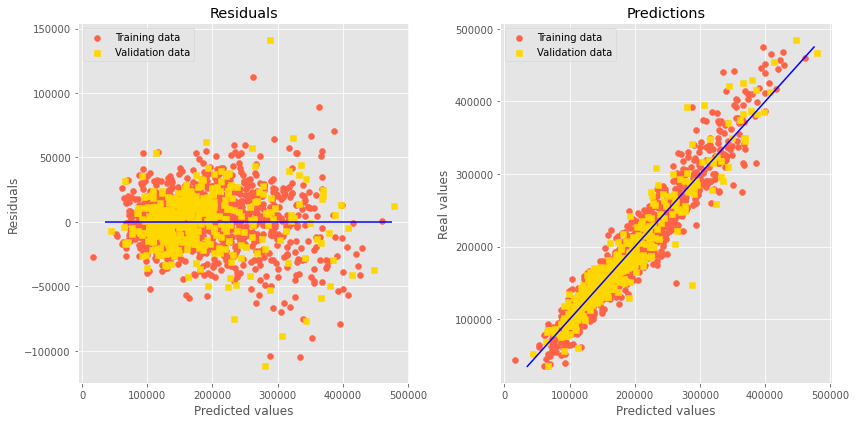

In [59]:
model_evaluation_plots(lassocv, X_train, y_train, X_test, y_test)

### 8.4 comments :
- Results improved after inserting polynomial features
- RMSE scores are lower, and R2 scores are slighlty higher
- Residual plot also see less spread of the data

## 8.5  Lasso and Ridge Model after removing low coef columns

- filtering out top coefficients features

In [60]:
coef = pd.Series(lassocv.coef_, index = X_train.columns)
coef.sort_values(ascending = False, inplace = True) # sort value by importance of value

In [61]:
coef_sort = [i for i in coef[coef != 0].keys().sort_values()] # creating list of coef not equal to zero
len(coef_sort)

119

- Choosing features that is contributing to saleprice after regularisation

### 8.5.1 Lasso model

In [62]:
y = df_train_poly['SalePrice']
X = df_train_poly[coef_sort]

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42, test_size = 0.2)

In [64]:
print('X_train shape: ' + str(X_train.shape))
print('X_test shape: ' + str(X_test.shape))
print('y_train shape: ' + str(y_train.shape))
print('y_test shape: ' + str(y_test.shape))

X_train shape: (1614, 119)
X_test shape: (404, 119)
y_train shape: (1614,)
y_test shape: (404,)


In [65]:
lassocv = LassoCV(alphas = np.linspace(0.1,100,100), max_iter = 5000)
lassocv.fit(X_train, y_train);
lassocv.alpha_

10.19090909090909

In [66]:
print("Train Score(L2): " + str(lassocv.score(X_train,y_train)))
print("Test Score(L2): " + str(lassocv.score(X_test,y_test)))
print('Test Data Estimated score(L2) ' + str(cross_val_score(lassocv, X_train, y_train, cv = 5).mean()))

Train Score(L2): 0.9317787694105003
Test Score(L2): 0.9163450196381071
Test Data Estimated score(L2) 0.9123943178791531


In [67]:
print("Train RMSE(L2) " + str(np.sqrt(mean_squared_error(y_train, lassocv.predict(X_train)))))
print('Test RMSE(L2) ' + str(np.sqrt(mean_squared_error(y_test, lassocv.predict(X_test)))))
                              
print('Test Data Estimated RMSE(L2) ' + str(np.sqrt(-cross_val_score(lassocv, X_train, y_train, 
                                                            cv = 5, scoring = 'neg_mean_squared_error').mean())))

Train RMSE(L2) 18993.187634974543
Test RMSE(L2) 21691.534649589594
Test Data Estimated RMSE(L2) 21504.161111217458


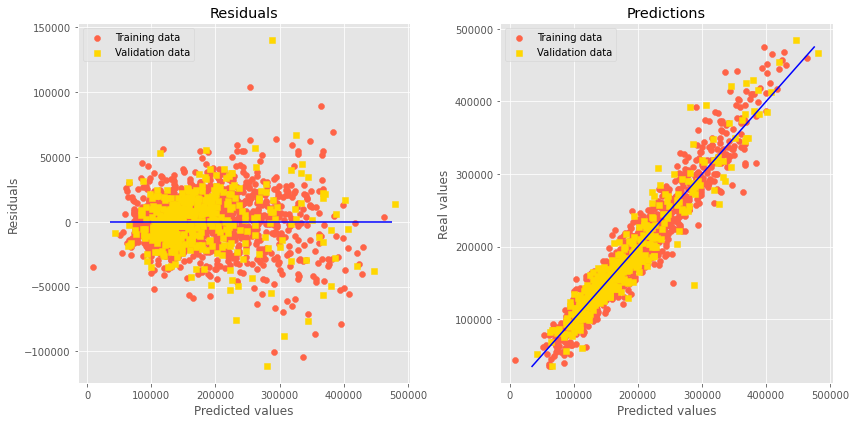

In [68]:
model_evaluation_plots(lassocv, X_train, y_train, X_test, y_test)

### 8.5.2 Ridge Model

In [69]:
ridgecv = RidgeCV(alphas = np.logspace(0.1,10,100))

In [70]:
ridgecv.fit(X_train, y_train);

In [71]:
ridgecv.alpha_

1.2589254117941673

In [72]:
print("Train Score(L1): " + str(ridgecv.score(X_train,y_train)))
print("Test Score(L1): " + str(ridgecv.score(X_test,y_test)))
print('Test Data Estimated score(L1) ' + str(cross_val_score(ridgecv, X_train, y_train, cv = 5).mean()))

Train Score(L1): 0.9312484794013147
Test Score(L1): 0.9164822785679052
Test Data Estimated score(L1) 0.9132665540077859


In [73]:
print("Train RMSE(L1) " + str(np.sqrt(mean_squared_error(y_train, ridgecv.predict(X_train)))))
print('Test RMSE(L1) ' + str(np.sqrt(mean_squared_error(y_test, ridgecv.predict(X_test)))))
                              
print('Test Data Estimated RMSE(L1) ' + str(np.sqrt(-cross_val_score(ridgecv, X_train, y_train, 
                                                            cv = 5, scoring = 'neg_mean_squared_error').mean())))

Train RMSE(L1) 19066.862653803124
Test RMSE(L1) 21673.731889285955
Test Data Estimated RMSE(L1) 21399.772319372285


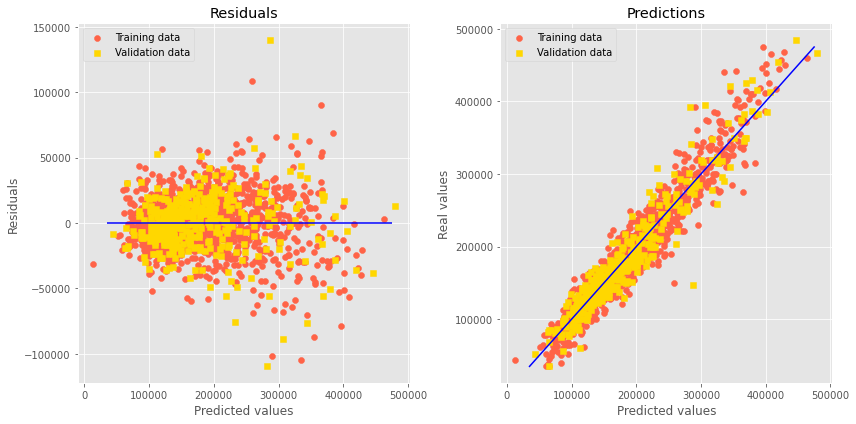

In [74]:
model_evaluation_plots(ridgecv, X_train, y_train, X_test, y_test)

### 8.5 Comments
- Decrease in RMSE, the gap between the R2 scores are smaller
- it can be inferred that the accuracy to unknown data is improved

## 8.6 Fit full train data to models for submission

In [75]:
ridge = Ridge(alpha = ridgecv.alpha_)
ridge.fit(X,y)

Ridge(alpha=1.2589254117941673)

In [76]:
lasso = Lasso(alpha = lassocv.alpha_)
lasso.fit(X,y)

Lasso(alpha=10.19090909090909)

# 9 Kaggle Submission
<a href='#9.-Kaggle-Submission'></a>
- will submit final prediction of lasso and ridge models to Kaggle

## 9.1 Preparing Test Data

In [77]:
# importing data for unknown test data prediction
df_test= pd.read_csv('../datasets/test_preprocess.csv')

df_test.shape

(879, 136)

In [78]:
# in test - train
df_test_col = df_test.columns.difference(df_train.columns)

# in train not in test
df_train_col =  df_train.columns.difference(df_test.columns)

# dropping values not in training set
df_test.drop(columns = df_test_col, inplace = True)

# adding values in training set not in testing set
for i in df_train_col:
    df_test[i] = 0
    
#filling in possible null values    
df_test.fillna(0 ,inplace = True)

#Creating Polynomial Features for unknown data
X_df_test = df_test[poly_coef]
X_test_poly = poly.fit_transform(X_df_test)

#Creating Polynomial Dataframe to add into test data
poly_test_features = pd.DataFrame(X_test_poly, columns=poly.get_feature_names(poly_coef))
poly_test_features.drop(poly_coef, axis = 1, inplace = True)

#adding features together for prediction models
df_test_poly = pd.concat([df_test, poly_test_features], axis = 1)


## 9.2 Predicting Saleprice of unknown test data

In [79]:
#setting test data with selected features
X_df_test = df_test_poly[coef_sort]

In [80]:
#predicting saleprice with ridge and lasso models
lasso_test_predict = lasso.predict(X_df_test)
ridge_test_predict = ridge.predict(X_df_test)

In [81]:
#checking the prediction length is correct
print(len(lasso_test_predict))
print(len(ridge_test_predict))

879
879


In [82]:
#creating DataFrame for predicted values
df_lasso_predicted = pd.DataFrame(lasso_test_predict, columns = ['SalePrice'])
df_ridge_predicted = pd.DataFrame(ridge_test_predict, columns = ['SalePrice'])

In [83]:
#checking prediction results
print(df_lasso_predicted.head())
print(df_ridge_predicted.head())

       SalePrice
0  125410.801659
1  156661.405735
2  185331.840044
3  109811.888782
4  178144.898299
       SalePrice
0  125264.222747
1  156551.311240
2  184895.657403
3  110114.814467
4  178051.008553


In [84]:
#creating DataFrame to export later
submit_lasso = pd.concat([df_test['Id'], df_lasso_predicted['SalePrice']], 
                   ignore_index=False, sort=False, axis = 1)

submit_ridge = pd.concat([df_test['Id'], df_ridge_predicted['SalePrice']], 
                   ignore_index=False, sort=False, axis = 1)


In [85]:
#sorting data for submission
submit_lasso.sort_values('Id', ascending = True, inplace = True)
submit_lasso.head()

,Id,SalePrice
704,2,114677.470916
706,4,290633.778108
120,6,191378.411919
312,7,231325.043239
401,17,197658.990153


In [86]:
#sorting data for submission
submit_ridge.sort_values('Id', ascending = True, inplace = True)
submit_ridge.head()

,Id,SalePrice
704,2,116072.578452
706,4,290070.868700
120,6,191415.855354
312,7,230782.834987
401,17,197771.834753


In [87]:
submit_lasso.to_csv("../datasets/submission_lasso.csv", index=False)
submit_ridge.to_csv("../datasets/submission_ridge.csv", index=False)

## 9.3 Submission result

![submission.PNG](https://raw.githubusercontent.com/SimYiSY/Ames_Housing_Data/master/images/submission.PNG)

# 10. Analysis
<a href='#10.-Analysis'></a>

- Plotting out charts to see which features has an impact on SalePrice
- List down a few features homeowners should look out for

In [88]:
coef_50 = coef[abs(coef).sort_values(ascending = False)[:50].keys()].sort_values(ascending = False) 
#top 50 coef for reccomendation

In [89]:
df_coef_50 = pd.DataFrame(coef_50).reset_index().rename(columns = {'index': 'Features', 0: 'Coefficient'}) #ranking the coef
df_coef_50.head(10) 

,Features,Coefficient
0,Neighborhood_GrnHill,90402.370031
1,Neighborhood_StoneBr,29381.559499
2,Total Flr SF,20997.324624
3,Neighborhood_NridgHt,20266.348785
4,Exterior 1st_BrkFace,19128.294030
5,Neighborhood_NoRidge,17725.178869
6,Neighborhood_ClearCr,16970.425957
7,Bldg Type_2fmCon,13620.120672
8,Bldg Type_1Fam,13562.684905
9,Overall Total Value,12828.437487


In [90]:
df_coef_50.tail(10)

,Features,Coefficient
40,MS Zoning_RM,-4583.006188
41,Neighborhood_Edwards,-5647.572627
42,Exterior 2nd_ImStucc,-6693.671386
43,Condition 1_RRNn,-7124.554203
44,Neighborhood_NWAmes,-7681.415829
45,Neighborhood_Blmngtn,-7683.982857
46,Bldg Type_Twnhs,-8679.381053
47,Heating_Grav,-12872.553787
48,MS Zoning_C (all),-15613.981703
49,Roof Style_Mansard,-34353.505076


In [91]:
df_coef_50.groupby('Features')['Coefficient'].sum()

Features
1st Flr SF                  11430.515366
1st Flr SF Garage Cars       3590.097198
1st Flr SF Year Built        3706.417468
Bldg Type_1Fam              13562.684905
Bldg Type_2fmCon            13620.120672
Bldg Type_Twnhs             -8679.381053
Bsmt Qual                    6081.354482
Condition 1_Artery          -4033.582054
Condition 1_Norm             5093.054024
Condition 1_PosA            10241.538306
Condition 1_PosN             9147.192682
Condition 1_RRNn            -7124.554203
Exterior 1st_BrkFace        19128.294030
Exterior 2nd_ImStucc        -6693.671386
Fireplace Total Value        4331.355418
Garage Cars                  3676.370804
Garage Cars Kitchen Qual     3517.974147
Garage Total Value           7400.669824
Garage Type_Attchd           3401.119186
Heating_Grav               -12872.553787
House Style_2.5Unf           5877.419329
House Style_SFoyer           6402.930556
Kitchen Qual                 4392.680646
Land Contour_Bnk            -4180.009103
Land Co

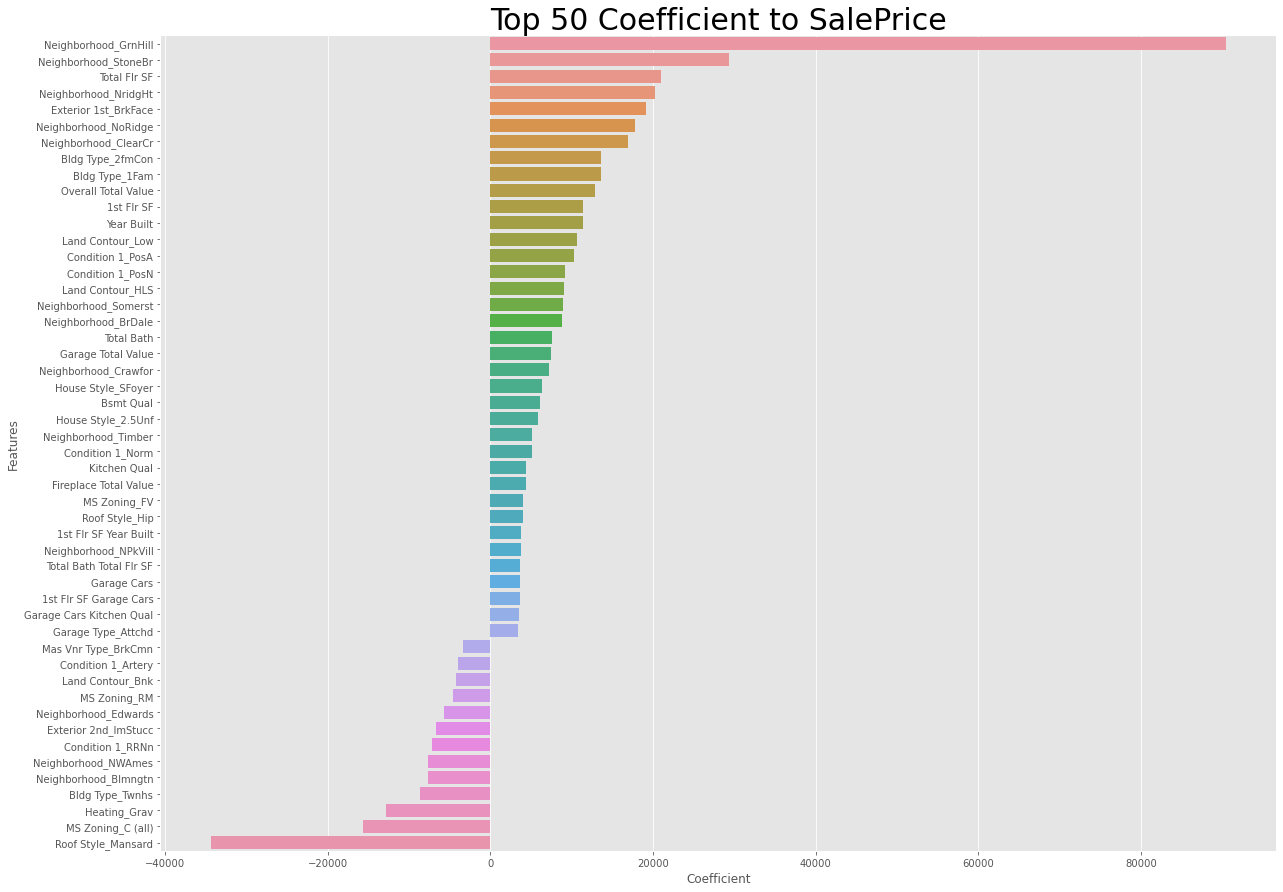

In [92]:
plt.figure(figsize= (20, 15))
plt.title('Top 50 Coefficient to SalePrice',fontdict = {'fontsize': 30})
sns.barplot(x = df_coef_50['Coefficient'], y = df_coef_50['Features']);

## 10 comments 
- From a glance, it looks like the location where the house is built matters the most for saleprice
  - Neighborhood seems to affect salesprice the most
  - Condition of the house (Proximity to main road or railroad), where it is near to main and railroad on both conditions seems to improve saleprice


- will attempt to remove features that homeowners are unable to make changes to their house (e.g Neighborhood, Condition, Land Contour)


In [93]:
df_recommend = df_coef_50[~df_coef_50['Features'].str
                          .contains('Neigh|Cond|Land')].sort_values(by = 'Coefficient', 
                                                                    ascending = False)
print((str(len(df_recommend['Features'])) + ' features recommended'))
df_recommend

29 features recommended


,Features,Coefficient
2,Total Flr SF,20997.324624
4,Exterior 1st_BrkFace,19128.294030
7,Bldg Type_2fmCon,13620.120672
8,Bldg Type_1Fam,13562.684905
9,Overall Total Value,12828.437487
10,1st Flr SF,11430.515366
11,Year Built,11354.676129
18,Total Bath,7596.935375
19,Garage Total Value,7400.669824
21,House Style_SFoyer,6402.930556


- plotting categories to view how does each feature impact property value

In [94]:
#function to plot barplot within categories
def barh_plot(label, df = df_recommend):
    dataframe = df[df['Features'].str.contains(label)].sort_values(by = 'Coefficient', ascending = False)
    plt.figure(figsize= (10, 6))
    plt.title(str(label) + ' Features Coefficient')
    sns.barplot(x = dataframe['Coefficient'], y = dataframe['Features']);

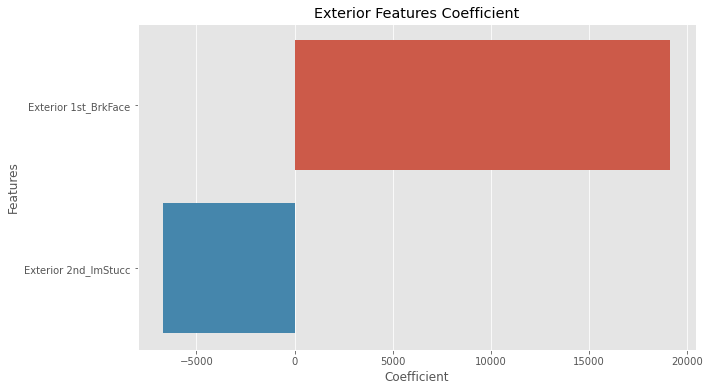

In [95]:
barh_plot('Exterior')

Comments: 

- Houses with better quality exterior tend to fetch a better price

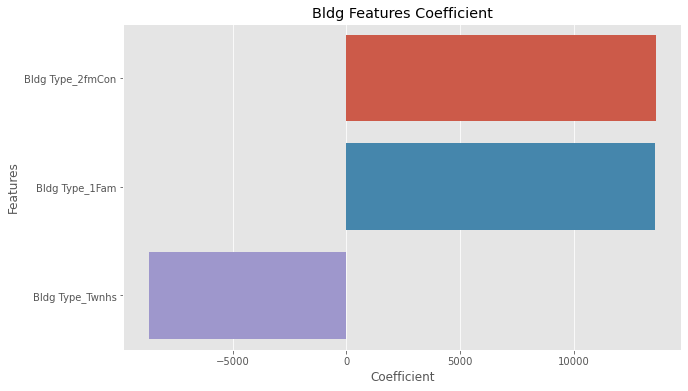

In [96]:
barh_plot('Bldg')

Comments:

Features that has a higher coefficient to SalePrice   
- 1Fam Single-family Detached
- 2FmCon Two-family Conversion; originally built as one-family dwelling

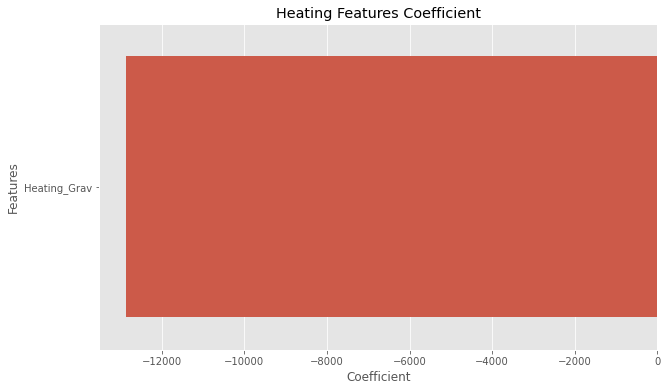

In [97]:
barh_plot('Heating')

Comments:

- good to note that having a heating of the below categories lowers the value of property significantly
  - Grav Gravity furnace

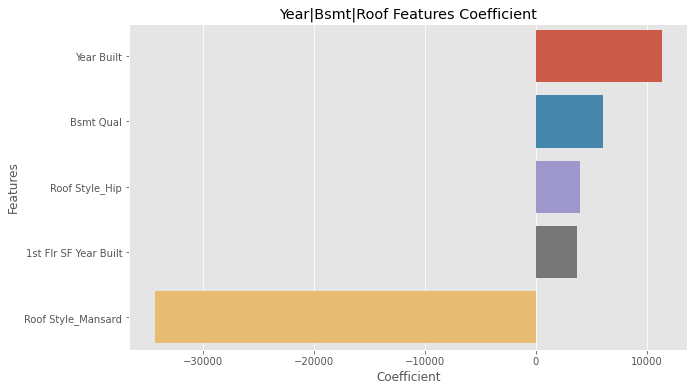

In [98]:
barh_plot('Year|Bsmt|Roof')

Comments:

- The newer the property, the higher the SalePrice
- Having a good Basement quality improves sale price
- Avoiding Mansard roof for the property as it negatively impact SalePrice significantly

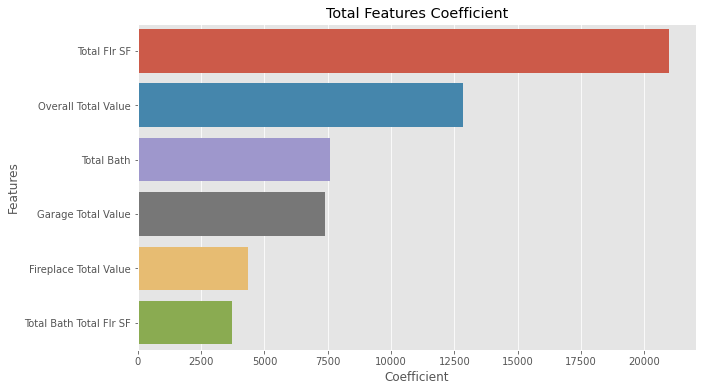

In [99]:
barh_plot('Total')

Comments: 

- Improving the overall quality the houses will increase value of property
- Total Flr SF, the bigger the space, the better
- Quality of house will improve the SalePrice as it gets better
- The Total Value of the Garage has an positive impact on Saleprice
- Total Bath, the more bath, the better

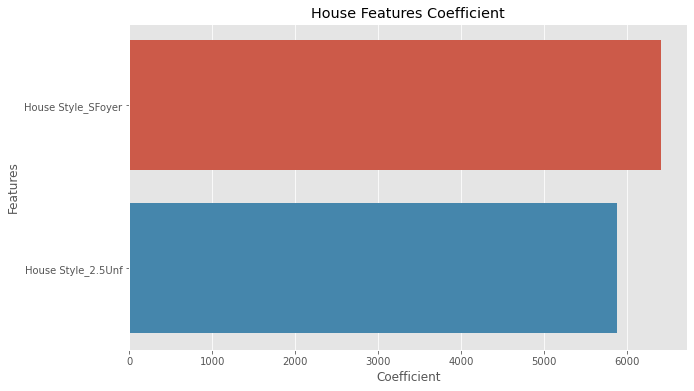

In [100]:
barh_plot('House')

Comments:

Features that improve value:
- SFoyer Split Foyer
- 2.5Unf Two and one-half story: 2nd level unfinished

Features that reduce value:
- 2.5Fin Two and one-half story: 2nd level finished
- 2Story Two story

Interesting to note that, having a unfinished 2nd level of a 2.5 story building actually fetches a better price then a finished one. There might be some other factors that has to be put into consideration

## 10.1 Business Recommendations:

**Most valuable features**
<br>Location of the house matters, as most of the high coefficient features are Neighbourhood, condition and land contour of the property.

**Least valuable features**
<br>Generally having a less quality and older building will affect the property's value. 

**Features for homeowners to consider**
<br>Ames House buyers generally values luxury, quality and space of the houses
<br>Certain features enhancement will improve saleprice: Heating, Fireplace, Garage, Baths
<br>Having a good exterior of the house will fetch a higher price
<br>The newer the house, the better the price

**Will the model generalize to other cities?**
<br>No, as the features that are used here are mostly related to Iowa and not other locations. Certain features might not be as relevant as compared to other places. 

**How to improve the model from here?**
<br>If possible, adding a few more features would be good for predicting the price of a property, as our findings has shown that location of the property matter most. features such as supermarkets, schools or malls that are near the property might be a few good features to consider collecting

<br>As for modeling wise, we can consider using more intricate models like RandomForest or XGboost to get a more accurate score.